In [0]:
import tensorflow as tf


In [0]:
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4TEEJQ/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4TEEJQ/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4TEEJQ/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4TEEJQ/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [0]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [0]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [0]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [0]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [0]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [0]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

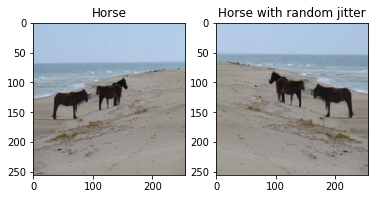

In [19]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

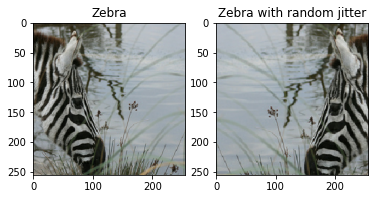

In [20]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [0]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


In [0]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

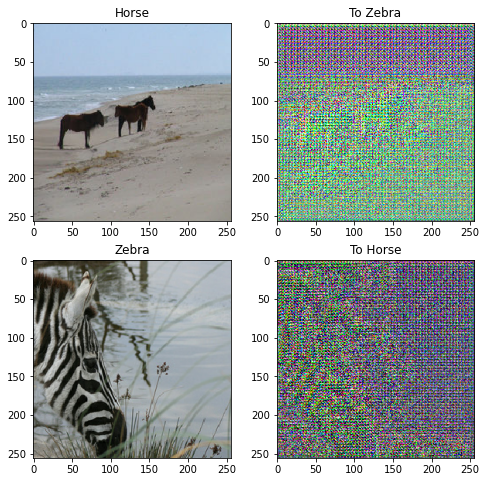

In [23]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

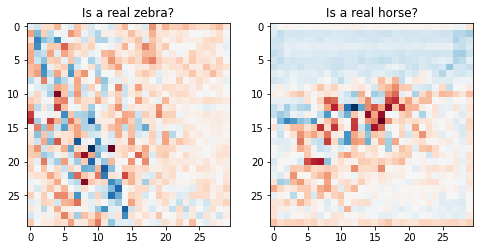

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [0]:
LAMBDA = 10

In [0]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')